In [68]:
import matplotlib.pyplot as plt
import seaborn as sns 
from IPython.display import Image
from sklearn import ensemble
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV 
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif 
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import accuracy_score,confusion_matrix,\
 classification_report
from sklearn.tree import DecisionTreeClassifier
import graphviz
import numpy as np
import pandas as pd
import pydotplus
import scipy.stats as stats
import timeit
from sklearn.utils import column_or_1d 

In [69]:
df = pd.read_csv('Student_Data.csv',encoding='Latin-1') #how we choose the encoding?
df.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M


* Gender - student's gender (nominal: 'Male' or 'Female’)
* Relation - Parent responsible for student (nominal:’mom’,’father’)
* Raised hand- how many times the student raises his/her hand on classroom (numeric:0-100)
* Visited resources- how many times the student visits a course content(numeric:0-100)
* Viewing announcements-how many times the student checks the new announcements(numeric:0-100)
* Discussion groups- how many times the student participate on discussion groups (numeric:0-100)
* Student Absence Days-the number of absence days for each student (nominal: above-7, under-7)

#### CONTINUOUS VARIABLES:
* raisedhands
* Visited resource
* Viewing announcements
* Discussion groups

SOURCE: Elaf Abu Amrieh, Thair Hamtini, and Ibrahim Aljarah, The University of Jordan, Amman, Jordan, http://www.Ibrahimaljarah.com www.ju.edu.jo

# Data exploration & visualization

In [70]:
df.describe()

,raisedhands,VisITedResources,AnnouncementsView,Discussion
count,480.000000,480.000000,480.000000,480.000000
mean,46.775000,54.797917,37.918750,43.283333
std,30.779223,33.080007,26.611244,27.637735
min,0.000000,0.000000,0.000000,1.000000
25%,15.750000,20.000000,14.000000,20.000000
50%,50.000000,65.000000,33.000000,39.000000
75%,75.000000,84.000000,58.000000,70.000000
max,100.000000,99.000000,98.000000,99.000000


The % distribution of Gender is: 
M    64.0
F    36.0
Name: gender, dtype: float64


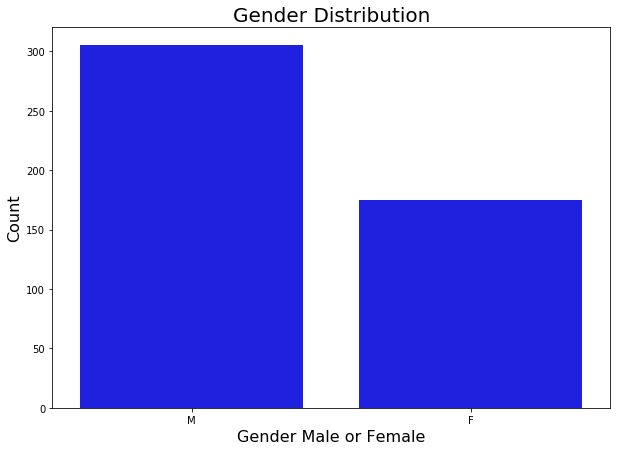

M    305
F    175
Name: gender, dtype: int64

In [71]:
# Gender 

print("The % distribution of Gender is: ")
print(round(df['gender'].value_counts(normalize=True),2)*100)

plt.figure(figsize=(10,7))

g = sns.countplot(df["gender"], color='blue')
g.set_title("Gender Distribution", fontsize=20)
g.set_ylabel('Count', fontsize=16)
g.set_xlabel('Gender Male or Female', fontsize=16)

plt.show()

df['gender'].value_counts()

We can see that 64% of employees are male and 36% are female.

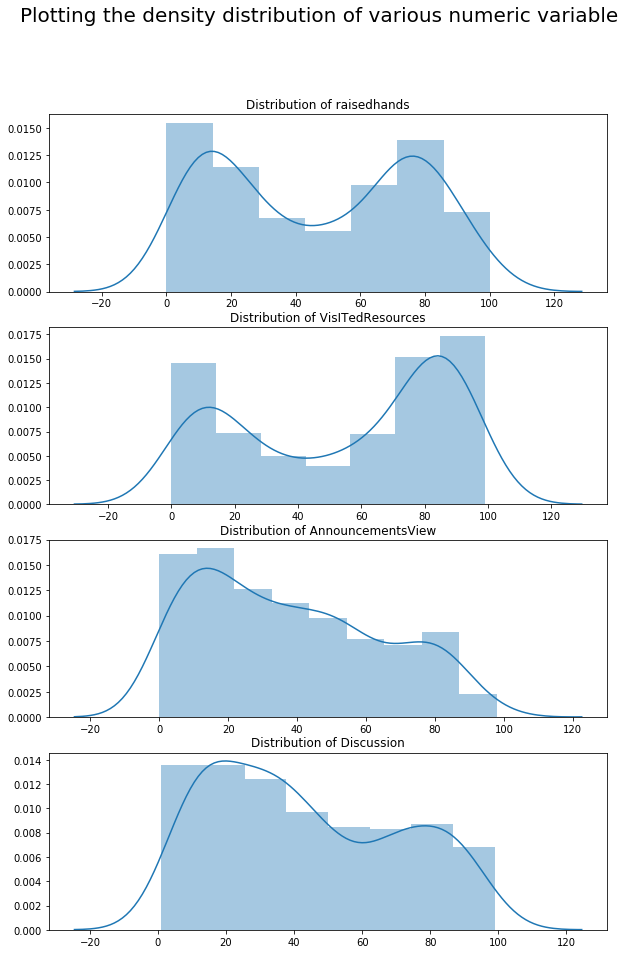

In [72]:
def draw_subplots(var_Name,tittle_Name,nrow=1,ncol=1,idx=1,fz=10): # Define a common module for drawing subplots.
    ax = plt.subplot(nrow,ncol,idx)                   #  idx - position of subplot in the main plotting window
    ax.set_title('Distribution of '+var_Name)         #  fz - the font size of Tittle in the main plotting window
    plt.suptitle(tittle_Name, fontsize=fz)

numeric_columns = ['raisedhands', 'VisITedResources', 'AnnouncementsView', 'Discussion']

fig,ax = plt.subplots(1,1, figsize=(10,15))
j=0  # reset the counter to plot 
title_Str="Plotting the density distribution of various numeric variable"

for i in numeric_columns:
    j +=1
    draw_subplots(i,title_Str,4,1,j,20) # create a 1x3 subplots for plotting distribution plots
    sns.distplot(df[i])
    plt.xlabel('')

We can get some observations from Density plots. First, the four variables(raisedhands, VisITedResources, AnnouncementsView,Discussion) are all not normal distribution. The distribution of raisedhands and VisITedResources is polarization. The distribution of AnnouncementsView and Discussion present a decreasing trend.

# Holdout (splitting data)

In [73]:
x = df[['raisedhands','VisITedResources','AnnouncementsView','Discussion']]
y = df[['gender']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=0)

# Select Kbest

In [74]:
x_new = SelectKBest(score_func=f_classif, k='all')
x_new.fit_transform(x_train, y_train)
print(x_new.get_support())

[ True  True  True  True]


C:\Users\mzz00\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


All four variables are selected. 

## Decision Tree Model

### Criterion: Entropy (Information Gain)

In [75]:
start_time = timeit.default_timer()

for i in range(1,11,1):
    decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = i, random_state = 0)
    X = df[['raisedhands','VisITedResources','AnnouncementsView','Discussion']]
    Y = df['gender']
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
    decision_tree.fit(X_train,Y_train)

    dot_data = tree.export_graphviz(decision_tree, out_file = None, feature_names = X_train.columns, class_names=['Male', 'Female'], filled=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    Image(graph.create_png())
    print('Depth: {}'.format(i))
    print('Model Performance: {:.2%}.\n'.format(cross_val_score(decision_tree, X_train, Y_train, cv=10).mean()))

print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

Depth: 1
Model Performance: 56.14%.

Depth: 2
Model Performance: 57.53%.

Depth: 3
Model Performance: 56.54%.

Depth: 4
Model Performance: 58.22%.

Depth: 5
Model Performance: 55.83%.

Depth: 6
Model Performance: 56.17%.

Depth: 7
Model Performance: 55.89%.

Depth: 8
Model Performance: 55.94%.

Depth: 9
Model Performance: 56.91%.

Depth: 10
Model Performance: 56.88%.

--- Runtime: 8.854502564102859 seconds. ---


### Best-Performing Tree: max_depth = 2

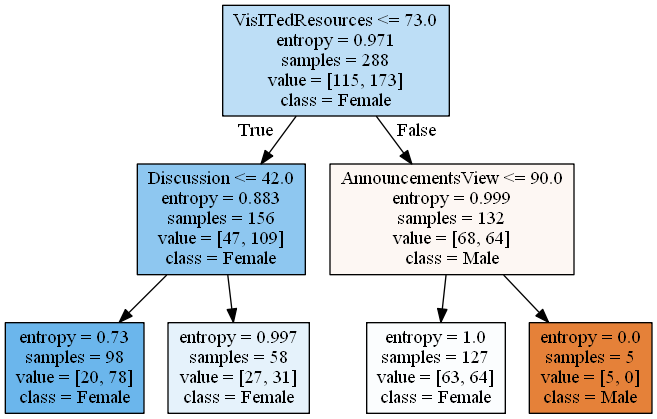

In [76]:
decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 2, random_state = 0)
X = df[['raisedhands','VisITedResources','AnnouncementsView','Discussion']]
Y = df['gender']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
decision_tree.fit(X_train,Y_train)

dot_data = tree.export_graphviz(decision_tree, out_file = None, feature_names = X_train.columns, class_names=['Male', 'Female'], filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [77]:
start_time = timeit.default_timer()

decision_tree = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 2, random_state = 0)
X = df[['raisedhands','VisITedResources','AnnouncementsView','Discussion']]
Y = df['gender']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
dtmodel=decision_tree.fit(X_train,Y_train)

dot_data = tree.export_graphviz(decision_tree, out_file = None, feature_names = X_train.columns, class_names=['Male', 'Female'], filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

print("--- Runtime: %s seconds. ---" % (timeit.default_timer() - start_time))

--- Runtime: 0.37217476923069626 seconds. ---


### gridsearchCV

In [78]:
dt=tree.DecisionTreeClassifier()
max_depth = range(1,10,1)
min_samples_leaf = range(1,10,2)
tuned_parameters = dict(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
clf = GridSearchCV(dt,tuned_parameters, cv=10)
clf.fit(X_test, Y_test)

print(" Best_score： %.4lf" %clf.best_score_)

print(" Best_params：", clf.best_params_)


 Best_score： 0.6823
 Best_params： {'max_depth': 1, 'min_samples_leaf': 1}


### Cross validation

In [79]:
scores = cross_val_score(decision_tree, X_train, Y_train, cv=10)
print(scores)

[0.6        0.66666667 0.6        0.51724138 0.65517241 0.42857143
 0.53571429 0.57142857 0.57142857 0.60714286]


### Classification_report and Confusion matrix

In [80]:
Y_pred = dtmodel.predict(X_test) 

In [81]:
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

Classification report:
Accuracy:  0.6875
             precision    recall  f1-score   support

          F       0.02      0.50      0.03         2
          M       0.99      0.69      0.81       190

avg / total       0.98      0.69      0.81       192

Confusion matrix:
[[  1  59]
 [  1 131]]


## Random forest model

In [82]:
rfc = ensemble.RandomForestClassifier()
dtmodel_R=rfc.fit(X_test, Y_test)
names_importances = {}
for feature, importance in zip(X_test.columns, rfc.feature_importances_):
    names_importances[feature] = importance
    names_importances_desc = sorted(names_importances.items(), key=lambda x: x[1], reverse=True)
    names_importances_desc = pd.DataFrame(names_importances_desc, columns=['feature','importance'])
names_importances_desc

,feature,importance
0,AnnouncementsView,0.314053
1,Discussion,0.250538
2,VisITedResources,0.239147
3,raisedhands,0.196262


### gridsearchCV

In [83]:
parameters = {"n_estimators": range(1,11)}
clf = GridSearchCV(estimator=rfc, param_grid=parameters, cv=10)
clf.fit(X_test, Y_test)

print(" Best_score： %.4lf" %clf.best_score_)

print(" Best_params：", clf.best_params_)

 Best_score： 0.6615
 Best_params： {'n_estimators': 9}


### Cross validation

In [84]:
scores = cross_val_score(rfc, X_train, Y_train, cv=10)
print(scores)

[0.66666667 0.63333333 0.76666667 0.4137931  0.65517241 0.39285714
 0.57142857 0.53571429 0.60714286 0.46428571]


### Classification_report and Confusion matrix

In [85]:
Y_pred = dtmodel_R.predict(X_test) 

In [86]:
accuracy = accuracy_score(Y_test,Y_pred)
report = classification_report(Y_pred, Y_test)
cm = confusion_matrix(Y_test,Y_pred)

print("Classification report:")
print("Accuracy: ", accuracy)
print(report)
print("Confusion matrix:")
print(cm)

Classification report:
Accuracy:  0.9895833333333334
             precision    recall  f1-score   support

          F       0.97      1.00      0.98        58
          M       1.00      0.99      0.99       134

avg / total       0.99      0.99      0.99       192

Confusion matrix:
[[ 58   2]
 [  0 132]]


# PCA

In [110]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
X = df[['raisedhands','VisITedResources','AnnouncementsView','Discussion']]
Y = df[['gender']]
X = StandardScaler().fit_transform(X)

sklearn_pca = PCA(n_components=4)
df["pca_1"] = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.62714744 0.20387185 0.09448235 0.07449836]
